# Mean Model
This model will predict the mean values for TTC as Q_time (time in FTS queue), N_time(time in the network) and T_Time (Q_time + N_time). Model is inferred from data over one week and used to predict the data over the next week.
For this model Feb/1 to Feb/8 for get the means and Feb/8 to Feb/14 to test the predictions.
* import libraries
* create the RSE to site mapping
* get the data
* calculate the means per link
* test against the data over the next week
* plot plot plot

In [10]:
#matplotlib stuff
%matplotlib inline
import matplotlib
matplotlib.rc('font', **{'size': 12})

# other imports
import datetime
from elasticsearch import Elasticsearch, helpers
from elasticsearch.helpers import scan
import datetime as dt
import json
import numpy as np
import pandas as pd
import pickle
import requests
import time
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2

In [2]:
# Get AGIS endpoints (RSEs) and site names
r = requests.get('http://atlas-agis-api.cern.ch/request/site/query/list/ddmendpoints?json')
j = r.json()
#Create RSE to site name dictionary
rse2site = {}
for i in j:
    for ep in i['ddmendpoints']:
        rse2site[ep]=i['name']

#### Get transfers from ElasticSearch for 7 days and calculate the mean for each link

In [3]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
DATE = '2017-02-01'  # yyyy-mm-dd
DELTA = 7
# Generate the indexes to scan
dt.datetime.strptime(DATE,'%Y-%m-%d')
index_list = []
for i in range(-1, DELTA+1):
    index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
indexes = ','.join(index_list)
print (index_list)

['fts_2017-01-31', 'fts_2017-02-01', 'fts_2017-02-02', 'fts_2017-02-03', 'fts_2017-02-04', 'fts_2017-02-05', 'fts_2017-02-06', 'fts_2017-02-07', 'fts_2017-02-08']


### This sniplet creates the model for mean predition for all the links

In [26]:
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=7)
transfer_query = {
    "size": 0,
    "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
    'query':{
        "bool" : {
            "must" : [
                {"range" : {"transferred_at" : {  "gte": period_start } }},
                {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                ]
        }
    }
                
}
model = {}
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
for res in scroll:
    r = res['_source']
    r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    # Calculate the mean incrementally for each link as mean = (mean * n + new_value)/(n+1)
    link = rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']]+'__'+r['activity']
    q_t = r['started_at'] - r['submitted_at']
    # calculate the rate mean for network times
    if (r['transferred_at'] - r['started_at']) > 0:
        n_t = r['bytes']/(r['transferred_at'] - r['started_at'])
    else:
        continue
    t_t = r['transferred_at'] - r['submitted_at']
    if link not in model.keys():
        model[link] = {}
        model[link]['q_t'] = q_t
        model[link]['n_t'] = n_t
        model[link]['t_t'] = t_t
        model[link]['n'] = 1
    else:
        model[link]['q_t'] = (model[link]['q_t'] * model[link]['n'] + q_t)/ (model[link]['n']+1)
        model[link]['n_t'] = (model[link]['n_t'] * model[link]['n'] + n_t)/ (model[link]['n']+1)
        model[link]['t_t'] = (model[link]['t_t'] * model[link]['n'] + t_t)/ (model[link]['n']+1)
        model[link]['n'] += 1
    count += 1
    if not count%1000000 : print (count,link, model[link])
print('Reading took',time.time() - st,'seconds.')
#data['QUEUE_T'] = data.STARTED - data.SUBMITTED
#data['NET_T'] = data.ENDED - data.STARTED
print('Links:', len(model.keys()))

1000000 NDGF-T1__UKI-NORTHGRID-LANCS-HEP__Production Input {'n': 1460, 'n_t': 1037892.9741757788, 'q_t': 185410.1424657535, 't_t': 185446.4595890411}
2000000 CERN-PROD__UNI-FREIBURG__Production Output {'n': 1206, 'n_t': 14974940.159773612, 'q_t': 47.268656716417865, 't_t': 51.72885572139303}
3000000 Taiwan-LCG2__GRIF-IRFU__Production Input {'n': 425, 'n_t': 613727.230586779, 'q_t': 449.43764705882353, 't_t': 522.1882352941184}
4000000 MWT2__UAM-LCG2__Data Consolidation {'n': 1030, 'n_t': 233951.1388062225, 'q_t': 185.30485436893213, 't_t': 198.87669902912629}
5000000 IN2P3-CC__TRIUMF-LCG2__Production Input {'n': 17215, 'n_t': 771794.259995394, 'q_t': 7191.848271855932, 't_t': 7206.752715654949}
6000000 BNL-ATLAS__RAL-LCG2__Data Consolidation {'n': 10864, 'n_t': 107440.48319094867, 'q_t': 5234.736653166404, 't_t': 5266.081921944012}
7000000 BU_ATLAS_Tier2__MWT2__Data Rebalancing {'n': 648, 'n_t': 8530315.204786364, 'q_t': 411.1265432098766, 't_t': 515.233024691358}
8000000 BU_ATLAS_Tier

# Warnign: Fugly code follows. Leaved as an example!!

#### Takes one week of data for CERN-PROD --->all destinations (Production Input)

In [61]:
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
data = []
for res in scroll:
    r = res['_source']
    # Only for links where CERN-PROD is source
    if rse2site[r['src_rse']] != 'CERN-PROD':
        continue
    if rse2site[r['dst_rse']] != 'BNL-ATLAS':
        continue
    if not count%100000 : print (count)
    r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    data.append([rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']]+'__'+r['activity'],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
    count += 1
print('Reading took',time.time() - st,'seconds.')
cern = pd.DataFrame(data, columns=['LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
cern['Q_TIME'] = cern['STARTED'] - cern['SUBMITTED']
cern['N_TIME'] = cern['ENDED'] - cern['STARTED']
cern['T_TIME'] = cern['ENDED'] - cern['SUBMITTED']



0
100000
Reading took 719.1178200244904 seconds.


#### Compute the errors

In [62]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
links = {}
st = time.time()
for row in cern.itertuples():
    link= row.LINK
    if link not in links:
        links[link] = []
        cut = cern.where(cern.LINK == link).dropna()
        if link in model.keys():
            links[link].append(mae(cut.Q_TIME, [model[link]['q_t']]*len(cut)))
            links[link].append(mae(cut.N_TIME, [model[link]['n_t']]*len(cut)))
            links[link].append(mae(cut.T_TIME, [model[link]['t_t']]*len(cut)))
            links[link].append(mse(cut.Q_TIME, [model[link]['q_t']]*len(cut)))
            links[link].append(mse(cut.N_TIME, [model[link]['n_t']]*len(cut)))
            links[link].append(mse(cut.T_TIME, [model[link]['t_t']]*len(cut)))
            links[link].append(r2(cut.Q_TIME, [model[link]['q_t']]*len(cut)))
            links[link].append(r2(cut.N_TIME, [model[link]['n_t']]*len(cut)))
            links[link].append(r2(cut.T_TIME, [model[link]['t_t']]*len(cut)))
        else:
            print('Warning! Link not in the model:', link)
            links[link] = [-1]*9
    else:
        continue
print('Processing took',time.time() - st,'seconds.')

Processing took 7.209083080291748 seconds.


#### Plot the errors

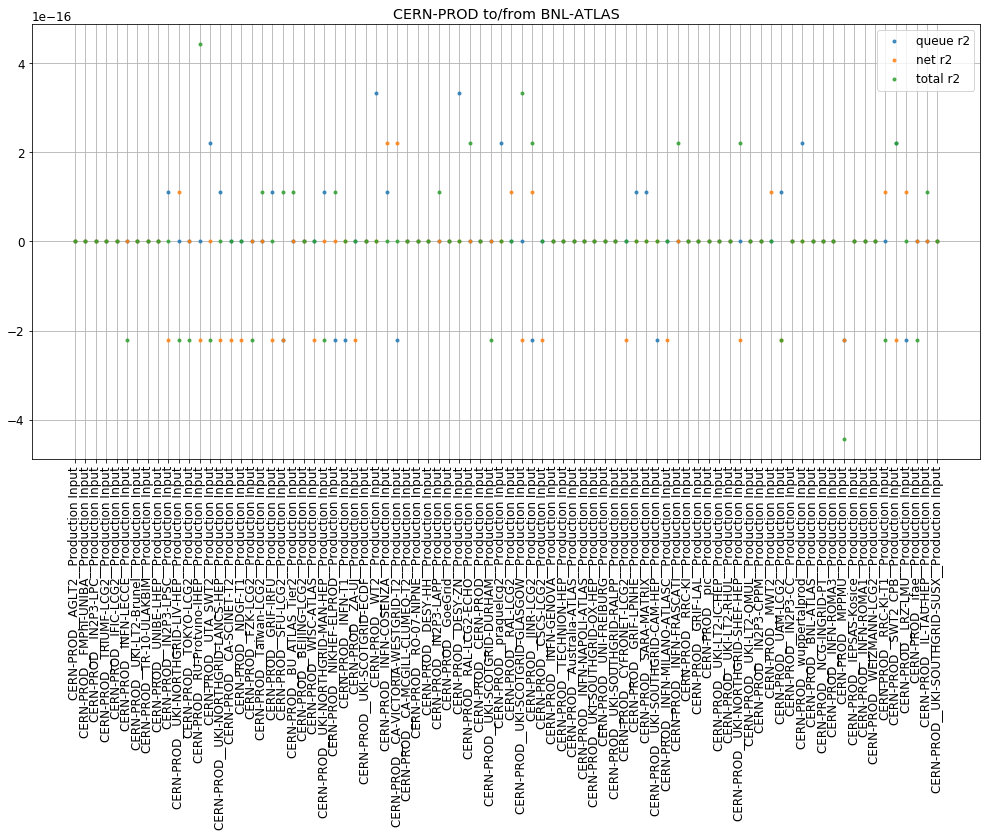

In [98]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.title('CERN-PROD to/from BNL-ATLAS')
#plt.plot([links[l][0] for l in links],'.', alpha=0.5, label='queue mae')
#plt.plot([links[l][1] for l in links],'.', alpha=0.5, label='net mae')
#plt.plot([links[l][2] for l in links],'.', alpha=0.5, label='total mae')
#plt.plot([links[l][3] for l in links],'.', alpha=0.5, label='queue mse')
#plt.plot([links[l][4] for l in links],'.', alpha=0.5, label='net mse')
#plt.plot([links[l][5] for l in links],'.', alpha=0.5, label='total mse')
plt.plot([links[l][6] for l in links],'.', alpha=0.8, label='queue r2')
plt.plot([links[l][7] for l in links],'.', alpha=0.8, label='net r2')
plt.plot([links[l][8] for l in links],'.', alpha=0.8, label='total r2')
plt.xticks(range(len(links.keys())), links.keys(), rotation='vertical')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

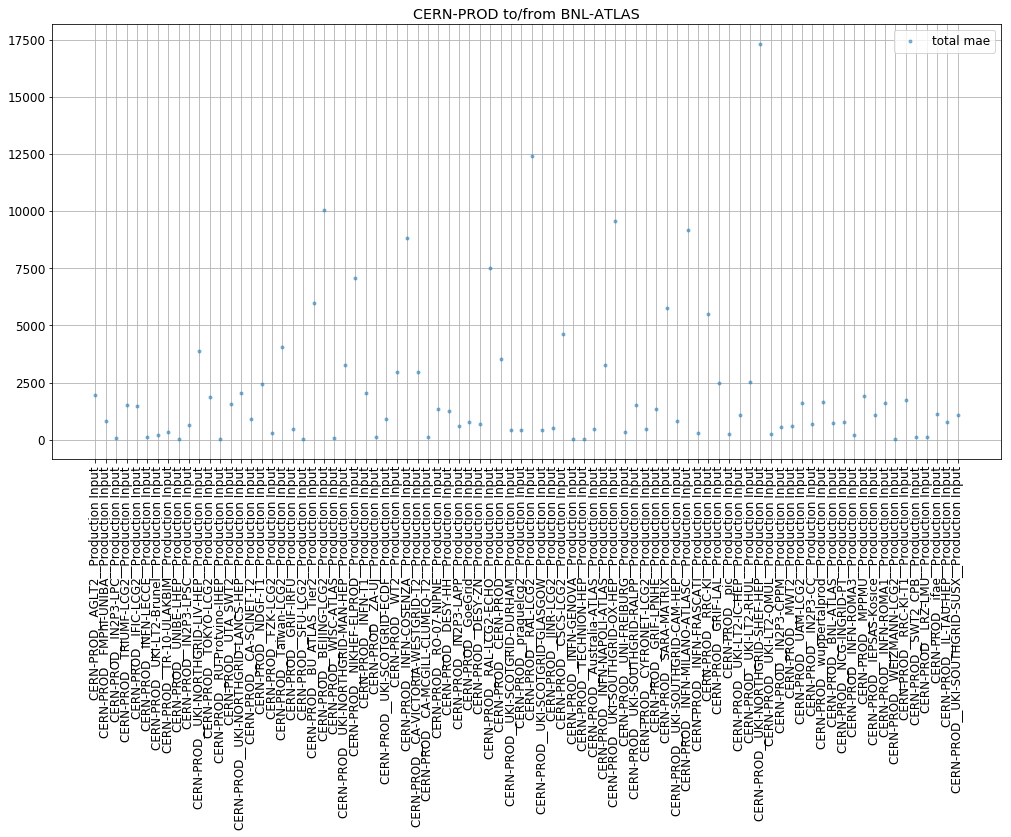

In [78]:
import matplotlib.dates as mdates
plt.title('CERN-PROD to/from BNL-ATLAS')
#plt.plot([links[l][0] for l in links],'.', alpha=0.5, label='queue mae')
#plt.plot([links[l][1] for l in links],'.', alpha=0.5, label='net mae')
plt.plot([links[l][2] for l in links],'.', alpha=0.5, label='total mae')
#plt.plot([links[l][3] for l in links],'.', alpha=0.5, label='queue mse')
#plt.plot([links[l][4] for l in links],'.', alpha=0.5, label='net mse')
#plt.plot([links[l][5] for l in links],'.', alpha=0.5, label='total mse')
#plt.plot([links[l][6] for l in links],'.', alpha=0.5, label='queue r2')
#plt.plot([links[l][7] for l in links],'.', alpha=0.5, label='net r2')
#plt.plot([links[l][8] for l in links],'.', alpha=0.5, label='total r2')
plt.xticks(range(len(links.keys())), links.keys(), rotation='vertical')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

# End of the not nice block. Follow a less ugly block

## Get 1 week (same as training) test data

In [27]:
scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
data = []
for res in scroll:
    r = res['_source']
    if not count%100000 : print (count)
    r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    data.append([rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']]+'__'+r['activity'],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
    count += 1
print('Reading took',time.time() - st,'seconds.')
cern = pd.DataFrame(data, columns=['LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
cern['Q_TIME'] = cern['STARTED'] - cern['SUBMITTED']
#cern['N_TIME'] = cern['ENDED'] - cern['STARTED']
cern['N_TIME'] = cern.SIZE/(cern['ENDED'] - cern['STARTED'])
cern['T_TIME'] = cern['ENDED'] - cern['SUBMITTED']
cern['Q_PRED'] = model[link]['q_t']
cern['N_PRED'] = model[link]['n_t']
cern['T_PRED'] = model[link]['t_t']


0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000
10000000
10100000
10200000
10300000
10400000
10500000
10600000
10700000
10800000
10900000
11000000
11100000
11200000
11300000
11400000
11500000
11600000
11700000
11800000
11900000
12000000
12100000
12200000
12300000

### Calculate the MEA, MSE and R² one link

In [1]:
src = 'CERN-PROD'
dst = 'BNL-ATLAS'
act = 'Production Input'
cut = cern.where(cern.LINK == src+'__'+dst+'__'+act).dropna()
mean_rate = (cut.SIZE / (cut.ENDED - cut.STARTED)).mean()
mean_pred = model[src+'__'+dst+'__'+act]
print (mean_rate, mean_pred)

NameError: name 'cern' is not defined

### plot stats for the link

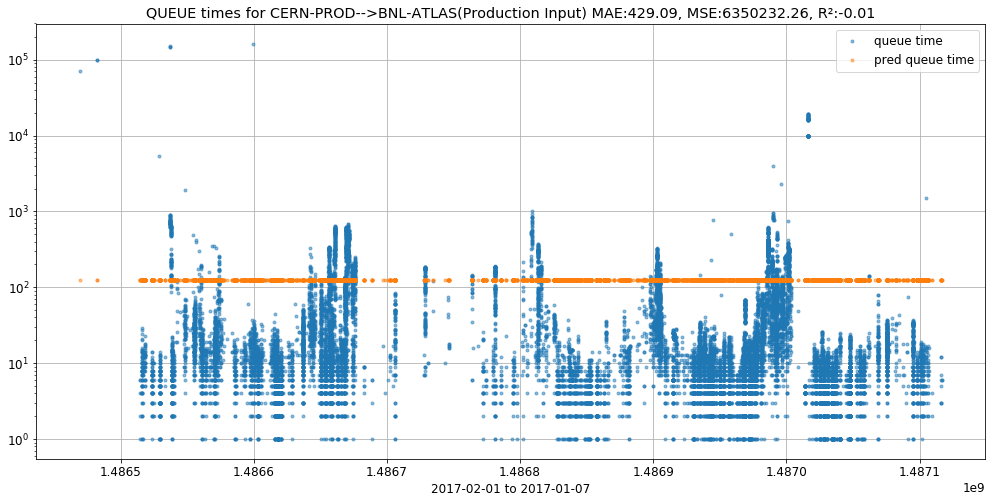

[   115642.33333333     72118.75           73948.125       19408313.6
    105765.33333333    197180.75          140904.2           147824.4
  11923392.02439024    126306.2       ]
[ 3758849.02498845  3758849.02498845  3758849.02498845  3758849.02498845
  3758849.02498845  3758849.02498845  3758849.02498845  3758849.02498845
  3758849.02498845  3758849.02498845]


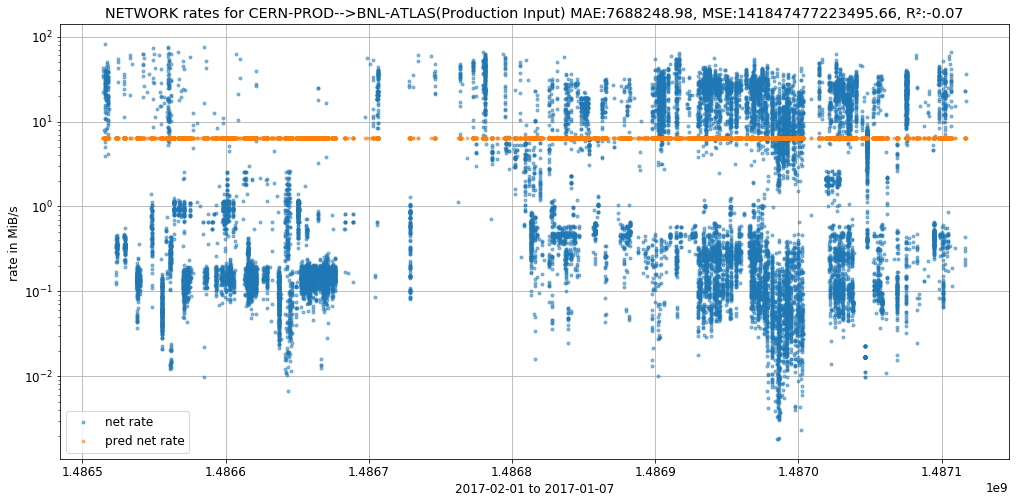

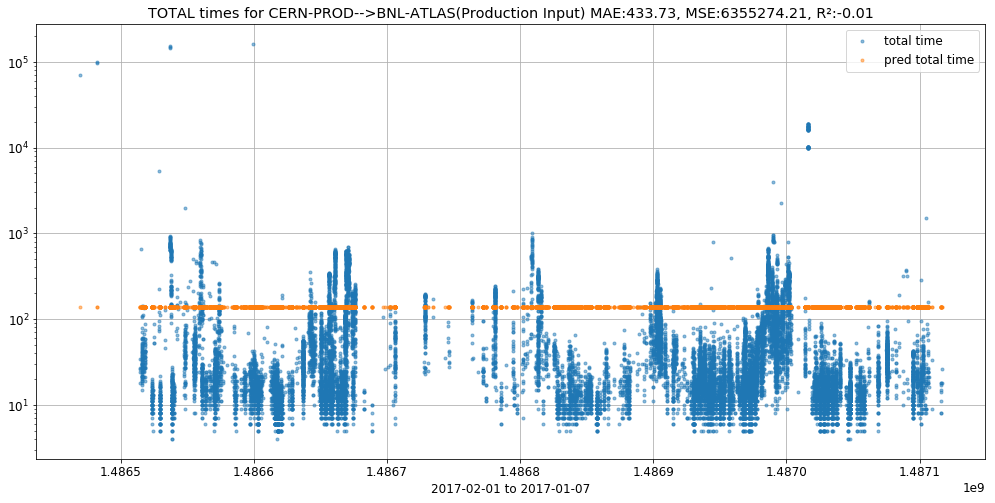

In [35]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
## QUEUE TIMES
q_mae = mae(cut.Q_TIME, cut.Q_PRED)
q_mse = mse(cut.Q_TIME, cut.Q_PRED)
q_r2 = r2(cut.Q_TIME, cut.Q_PRED)
plt.title('QUEUE times for '+ src+'-->'+dst+'('+act+') MAE:%0.02f, MSE:%0.02f, R²:%0.02f'%(q_mae, q_mse,q_r2))
plt.plot(cut.SUBMITTED,cut.Q_TIME,'.', alpha=0.5, label='queue time')
plt.plot(cut.SUBMITTED, [model[src+'__'+dst+'__'+act]['q_t']]*len(cut),'.', alpha=0.5, label='pred queue time')
#plt.xticks(range(len(links.keys())), links.keys(), rotation='vertical')
plt.xlabel('2017-02-01 to 2017-01-07')
plt.yscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

## NET TIMES
n_mae = mae(cut.N_TIME, cut.N_PRED)
n_mse = mse(cut.N_TIME, cut.N_PRED)
n_r2 = r2(cut.N_TIME, cut.N_PRED)
print(cut.N_TIME.values[:10])
print(cut.N_PRED.values[:10])
plt.title('NETWORK rates for '+ src+'-->'+dst+'('+act+') MAE:%0.02f, MSE:%0.02f, R²:%0.02f'%(n_mae, n_mse,n_r2))
plt.plot(cut.STARTED,cut.N_TIME/(1024*1024),'.', alpha=0.5, label='net rate')
plt.plot(cut.STARTED, [model[src+'__'+dst+'__'+act]['n_t']/(1024*1024)]*len(cut),'.', alpha=0.5, label='pred net rate')
#plt.xticks(range(len(links.keys())), links.keys(), rotation='vertical')
plt.xlabel('2017-02-01 to 2017-01-07')
plt.ylabel('rate in MiB/s ')
plt.yscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

## TOTAL TIMES
t_mae = mae(cut.T_TIME, cut.T_PRED)
t_mse = mse(cut.T_TIME, cut.T_PRED)
t_r2 = r2(cut.T_TIME, cut.T_PRED)
plt.title('TOTAL times for '+ src+'-->'+dst+'('+act+') MAE:%0.02f, MSE:%0.02f, R²:%0.02f'%(t_mae, t_mse,t_r2))
plt.plot(cut.SUBMITTED,cut.T_TIME,'.', alpha=0.5, label='total time')
plt.plot(cut.SUBMITTED, [model[src+'__'+dst+'__'+act]['t_t']]*len(cut),'.', alpha=0.5, label='pred total time')
#plt.xticks(range(len(links.keys())), links.keys(), rotation='vertical')
plt.xlabel('2017-02-01 to 2017-01-07')
plt.yscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

## Get 1 week (one week after training) of test data

In [31]:
es = Elasticsearch([{'host':'atlas-kibana.mwt2.org', 'port':9200}],timeout=60)
DATE = '2017-02-08'  # yyyy-mm-dd
DELTA = 7
# Generate the indexes to scan
dt.datetime.strptime(DATE,'%Y-%m-%d')
index_list = []
for i in range(-1, DELTA+1):
    index_list.append('fts_'+(dt.datetime.strptime(DATE,'%Y-%m-%d')
                      + dt.timedelta(days=i)).strftime('%Y-%m-%d'))
indexes = ','.join(index_list)
print (index_list)
period_start = dt.datetime.strptime(DATE,'%Y-%m-%d')
period_end = dt.datetime.strptime(DATE,'%Y-%m-%d') + dt.timedelta(days=7)
transfer_query = {
    "size": 0,
    "_source": ["src_rse", "dst_rse", "activity","bytes","submitted_at","started_at","transferred_at"],
    'query':{
        "bool" : {
            "must" : [
                {"range" : {"transferred_at" : {  "gte": period_start } }},
                {"range" : {"submitted_at" :   {  "lt" : period_end } }}
                ]
        }
    }
                
}

scroll = scan(client=es, index=indexes, query=transfer_query, scroll='5m', timeout="5m", size=10000)
epoch = dt.datetime(1970,1,1)
st = time.time()
count = 0
data = []
for res in scroll:
    r = res['_source']
    if not count%100000 : print (count)
    r['submitted_at'] = (dt.datetime.strptime(r['submitted_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['started_at'] = (dt.datetime.strptime(r['started_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    r['transferred_at'] = (dt.datetime.strptime(r['transferred_at'].strip('Z').split('.')[0], '%Y-%m-%dT%H:%M:%S') - epoch).total_seconds()
    data.append([rse2site[r['src_rse']]+'__'+rse2site[r['dst_rse']]+'__'+r['activity'],r['bytes'],r['submitted_at'],r['started_at'],r['transferred_at']])
    count += 1
print('Reading took',time.time() - st,'seconds.')
data = pd.DataFrame(data, columns=['LINK', 'SIZE', 'SUBMITTED', 'STARTED', 'ENDED'])
data['Q_TIME'] = data['STARTED'] - data['SUBMITTED']
data['N_TIME'] = data.SIZE/(data['ENDED'] - data['STARTED'])
data['T_TIME'] = data['ENDED'] - data['SUBMITTED']
data['Q_PRED'] = model[link]['q_t']
data['N_PRED'] = model[link]['n_t']
data['T_PRED'] = model[link]['t_t']


['fts_2017-02-07', 'fts_2017-02-08', 'fts_2017-02-09', 'fts_2017-02-10', 'fts_2017-02-11', 'fts_2017-02-12', 'fts_2017-02-13', 'fts_2017-02-14', 'fts_2017-02-15']
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
2100000
2200000
2300000
2400000
2500000
2600000
2700000
2800000
2900000
3000000
3100000
3200000
3300000
3400000
3500000
3600000
3700000
3800000
3900000
4000000
4100000
4200000
4300000
4400000
4500000
4600000
4700000
4800000
4900000
5000000
5100000
5200000
5300000
5400000
5500000
5600000
5700000
5800000
5900000
6000000
6100000
6200000
6300000
6400000
6500000
6600000
6700000
6800000
6900000
7000000
7100000
7200000
7300000
7400000
7500000
7600000
7700000
7800000
7900000
8000000
8100000
8200000
8300000
8400000
8500000
8600000
8700000
8800000
8900000
9000000
9100000
9200000
9300000
9400000
9500000
9600000
9700000
9800000
9900000
10000000
10100000
10200000
10300000
10400000
1050000

### Calculate the MEA, MSE and R² one link

In [37]:
src = 'CERN-PROD'
dst = 'BNL-ATLAS'
act = 'Production Input'
cut = data.where(data.LINK == src+'__'+dst+'__'+act).dropna()

### plot stats for the link

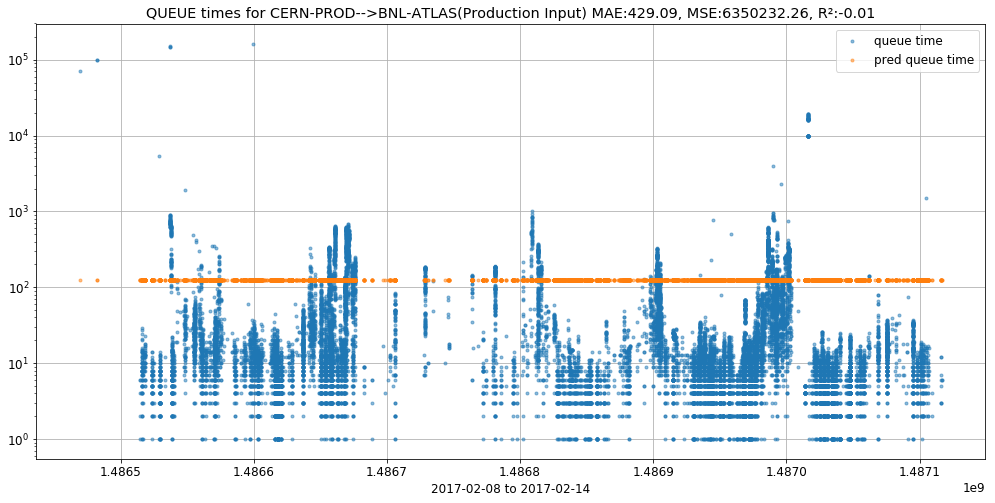

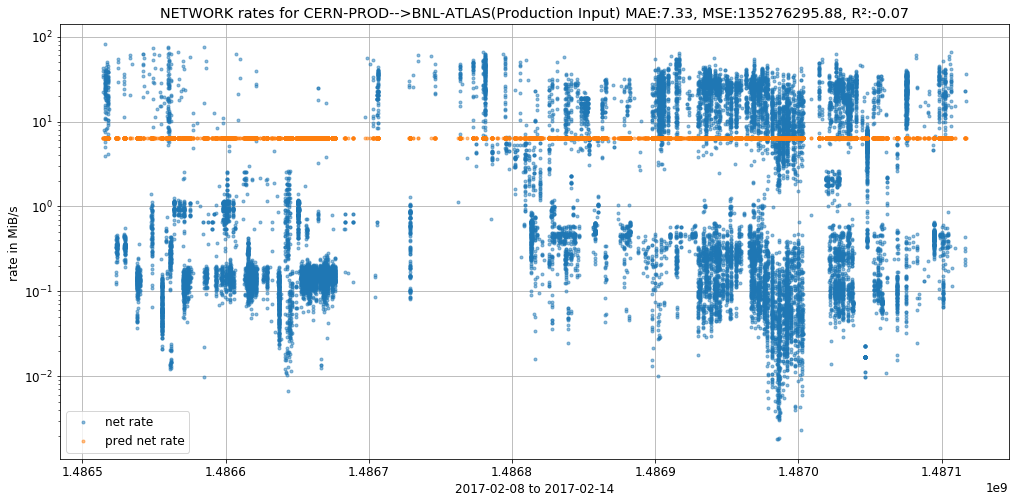

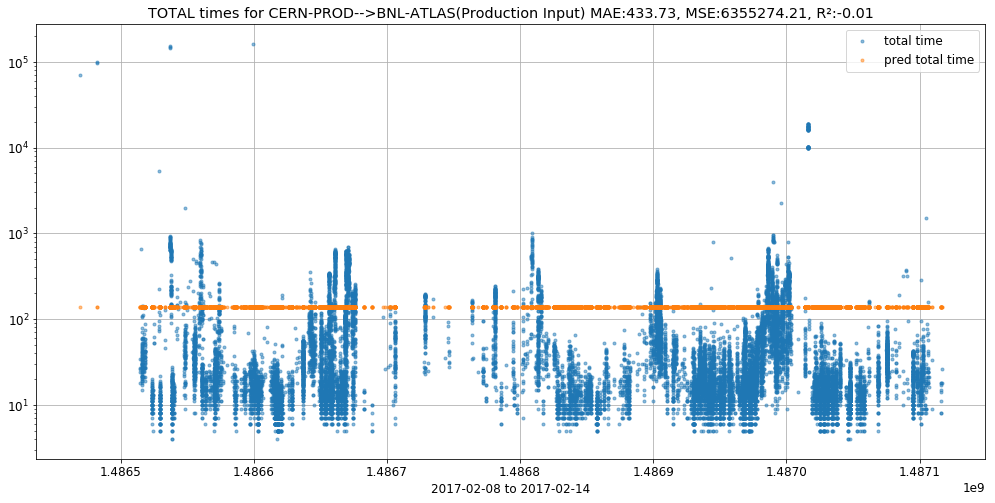

In [39]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
## QUEUE TIMES
q_mae = mae(cut.Q_TIME, cut.Q_PRED)
q_mse = mse(cut.Q_TIME, cut.Q_PRED)
q_r2 = r2(cut.Q_TIME, cut.Q_PRED)
plt.title('QUEUE times for '+ src+'-->'+dst+'('+act+') MAE:%0.02f, MSE:%0.02f, R²:%0.02f'%(q_mae, q_mse,q_r2))
plt.plot(cut.SUBMITTED,cut.Q_TIME,'.', alpha=0.5, label='queue time')
plt.plot(cut.SUBMITTED, [model[src+'__'+dst+'__'+act]['q_t']]*len(cut),'.', alpha=0.5, label='pred queue time')
#plt.xticks(range(len(links.keys())), links.keys(), rotation='vertical')
plt.xlabel('2017-02-08 to 2017-02-14')
plt.yscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

## NET TIMES
n_mae = mae(cut.N_TIME, cut.N_PRED)
n_mse = mse(cut.N_TIME, cut.N_PRED)
n_r2 = r2(cut.N_TIME, cut.N_PRED)
plt.title('NETWORK rates for '+ src+'-->'+dst+'('+act+') MAE:%0.02f, MSE:%0.02f, R²:%0.02f'%(n_mae/(1024*1024), n_mse/(1024*1024),n_r2))
plt.plot(cut.STARTED,cut.N_TIME/(1024*1024),'.', alpha=0.5, label='net rate')
plt.plot(cut.STARTED, [model[src+'__'+dst+'__'+act]['n_t']/(1024*1024)]*len(cut),'.', alpha=0.5, label='pred net rate')
#plt.xticks(range(len(links.keys())), links.keys(), rotation='vertical')
plt.xlabel('2017-02-08 to 2017-02-14')
plt.ylabel('rate in MiB/s ')
plt.yscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()

## TOTAL TIMES
t_mae = mae(cut.T_TIME, cut.T_PRED)
t_mse = mse(cut.T_TIME, cut.T_PRED)
t_r2 = r2(cut.T_TIME, cut.T_PRED)
plt.title('TOTAL times for '+ src+'-->'+dst+'('+act+') MAE:%0.02f, MSE:%0.02f, R²:%0.02f'%(t_mae, t_mse,t_r2))
plt.plot(cut.SUBMITTED,cut.T_TIME,'.', alpha=0.5, label='total time')
plt.plot(cut.SUBMITTED, [model[src+'__'+dst+'__'+act]['t_t']]*len(cut),'.', alpha=0.5, label='pred total time')
#plt.xticks(range(len(links.keys())), links.keys(), rotation='vertical')
plt.xlabel('2017-02-08 to 2017-02-14')
plt.yscale('log')
fig = plt.gcf()
fig.set_size_inches(17, 8)
plt.legend()
plt.grid()
plt.show()